Goal: Predict total number of citibike rides each day, based on variables such as year,month,day of week, temperature. etc.

Steps:
- Will do for one year to start, then extend
- Get total # rides grouped by day
- Get daily temperatures
- Separate into predictors/target
- Train/test split
- Fit linear regression, Ridge, Lasso models and evaluate performance.

In [ ]:
# import libraries and connect to database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
con = sqlite3.connect("data/citibike_database.db3")
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['lines.linewidth'] = 3

## Get total number of rides each day (target variable)

In [2]:
query = "SELECT year,month,day,wkday,count(*) as N FROM rides GROUP BY year,month,day"
df_rides = pd.read_sql_query(query,con)
df_rides['date'] = pd.to_datetime(df_rides[['year','month','day']])
df_rides.drop(['year','month','day'],axis=1,inplace=True)
df_rides.head()


,wkday,N,date
0,0,16650,2013-07-01
1,1,22745,2013-07-02
2,2,21864,2013-07-03
3,3,22326,2013-07-04
4,4,21842,2013-07-05


In [3]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Data columns (total 3 columns):
wkday    1362 non-null int64
N        1362 non-null int64
date     1362 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 32.0 KB


In [4]:
# write to CSV so we don't have to do long query again?
df_rides.to_csv('data/rides_dates_all.csv',index=False)

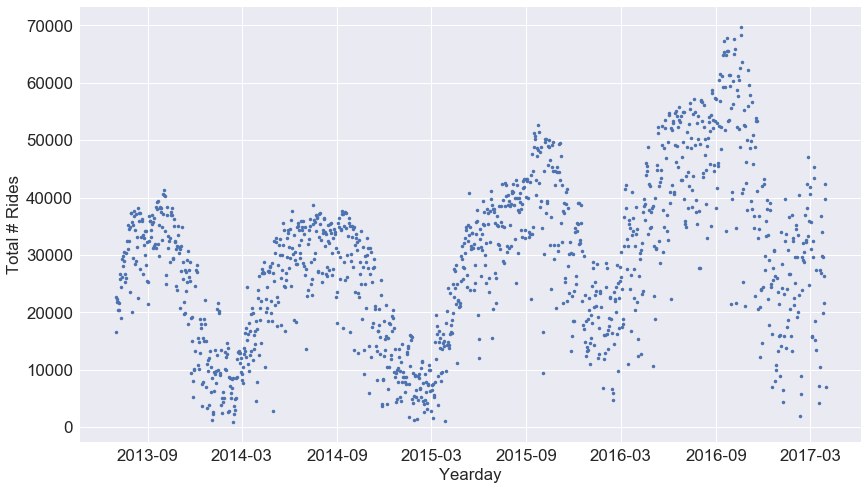

In [5]:
plt.figure(figsize=(14,8))
plt.plot(df_rides.date, df_rides.N,'.');
plt.xlabel('Yearday')
plt.ylabel('Total # Rides');

## get number of distinct stations each day (a feature)

In [6]:
query = "SELECT year,month,day,count(distinct start_station_id) as N_sta FROM rides GROUP BY year,month,day"
df_sta = pd.read_sql_query(query,con)
df_sta['date'] = pd.to_datetime(df_sta[['year','month','day']])
df_sta.drop(['year','month','day'],axis=1,inplace=True)
df_sta.head()

,N_sta,date
0,326,2013-07-01
1,327,2013-07-02
2,326,2013-07-03
3,324,2013-07-04
4,325,2013-07-05


In [7]:
df_sta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Data columns (total 2 columns):
N_sta    1362 non-null int64
date     1362 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 21.4 KB


In [8]:
df_sta.to_csv('data/sta_dates_all.csv',index=Falselse)

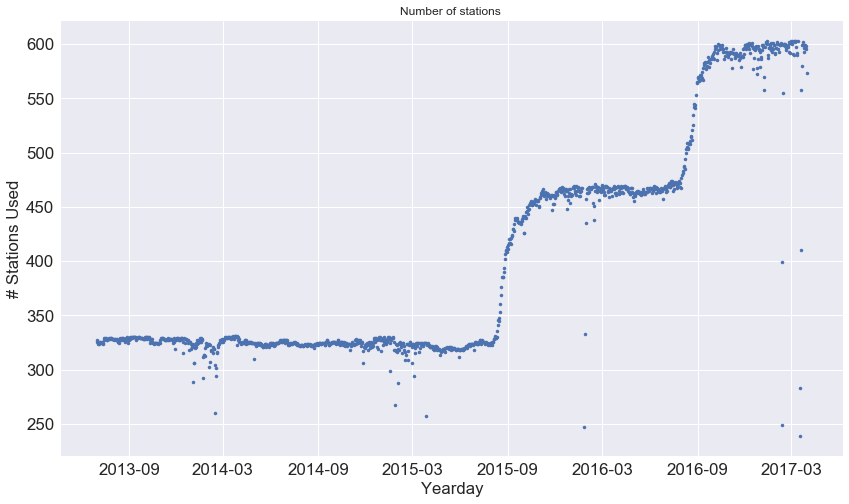

In [9]:

# Plot # stations vs yday (only counts tations that were used that day, so not necessarily
# all stations in service)
# NOTE spikes are likely days where not many rides taken
# should smooth these?
plt.figure(figsize=(14,8))
plt.plot(df_sta.date, df_sta.N_sta, '.');
plt.xlabel('Yearday')
plt.ylabel('# Stations Used');
plt.title('Number of stations ');

## Get daily weather (features)

In [10]:
con2 = sqlite3.connect('data/nyc_weather.db3')
query2 = "SELECT date,mean_temp as Tmean,precip_In,max_gust_mph,cloud_cover  FROM temps " 
df_wea = pd.read_sql_query(query2, con2)
df_wea.loc[df_wea.precip_In=='T'] = 0
df_wea.loc[:,'precip_In'] = df_wea.astype({'precip_In':'float64'})
df_wea['date'] = pd.to_datetime(df_wea['date'])
df_wea = df_wea[df_wea.date.dt.year>=2013]
df_wea.head()

,date,Tmean,precip_In,max_gust_mph,cloud_cover
1,2013-01-02,29,0.0,28.0,7
2,2013-01-03,30,0.0,26.0,5
3,2013-01-04,36,0.0,31.0,3
4,2013-01-05,39,0.0,33.0,3
6,2013-01-07,42,0.0,23.0,1


In [11]:
df_wea.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1420 entries, 1 to 1658
Data columns (total 5 columns):
date            1420 non-null datetime64[ns]
Tmean           1420 non-null int64
precip_In       1420 non-null float64
max_gust_mph    1416 non-null float64
cloud_cover     1420 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 66.6 KB


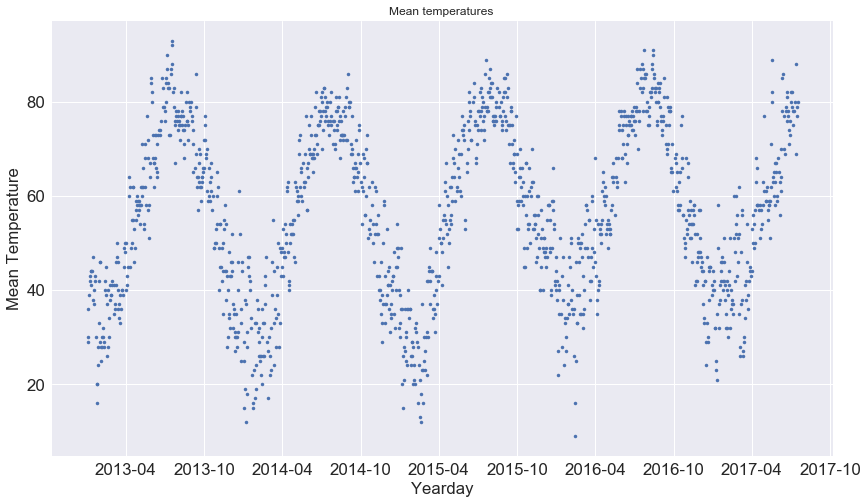

In [12]:
plt.figure(figsize=(14,8))
plt.plot(df_wea.date, df_wea.Tmean,'.');
plt.xlabel('Yearday')
plt.ylabel('Mean Temperature');
plt.title('Mean temperatures ' );

## Join data frames

In [14]:

#df_sta.drop(['year','month','day'],axis=1,inplace=True)


# join temps to rides data frame
df_comb = pd.merge(df_rides,df_wea,left_on='date',right_on='date')
# then merge to stations data frame
df_comb = pd.merge(df_comb, df_sta, left_on='date',right_on='date')
df_comb.head()

,wkday,N,date,Tmean,precip_In,max_gust_mph,cloud_cover,N_sta
0,0,16650,2013-07-01,76,0.73,26.0,8,326
1,1,22745,2013-07-02,78,0.06,23.0,7,327
2,2,21864,2013-07-03,80,0.96,23.0,7,326
3,3,22326,2013-07-04,84,0.00,24.0,4,324
4,4,21842,2013-07-05,85,0.00,23.0,1,325


In [15]:
df_comb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 0 to 1175
Data columns (total 8 columns):
wkday           1176 non-null int64
N               1176 non-null int64
date            1176 non-null datetime64[ns]
Tmean           1176 non-null int64
precip_In       1176 non-null float64
max_gust_mph    1173 non-null float64
cloud_cover     1176 non-null int64
N_sta           1176 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 82.7 KB


## create dummy variables for wkday

In [16]:
# NOTE drop_first drops redundant column from dummy vars
df_comb = pd.get_dummies(data=df_comb, columns=['wkday'],drop_first=True)
df_comb.head()

,N,date,Tmean,precip_In,max_gust_mph,cloud_cover,N_sta,wkday_1,wkday_2,wkday_3,wkday_4,wkday_5,wkday_6
0,16650,2013-07-01,76,0.73,26.0,8,326,0,0,0,0,0,0
1,22745,2013-07-02,78,0.06,23.0,7,327,1,0,0,0,0,0
2,21864,2013-07-03,80,0.96,23.0,7,326,0,1,0,0,0,0
3,22326,2013-07-04,84,0.00,24.0,4,324,0,0,1,0,0,0
4,21842,2013-07-05,85,0.00,23.0,1,325,0,0,0,1,0,0


## split data into predictor/target arrays in prep for modelling

In [ ]:
X = df_comb.drop(['date','N'], axis=1)
X.head()

In [ ]:
y = df_comb['N']
y.head()

## Split data into training/test sets

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.3, random_state=39)

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score

#imp = Imputer(strategy='most_frequent')
imp = Imputer(strategy='mean')
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test =imp.transform(X_test)
X_all = imp.transform(X)

reg = LinearRegression()
reg.fit(X_train,y_train)
preds = reg.predict(X_test)
np.mean(cross_val_score(reg,X_train,y_train))

In [ ]:
# score on training set
reg.score(X_train,y_train)

In [ ]:
# score on test set
reg.score(X_test,y_test)

In [ ]:
# plot predictions vs actual values
plt.figure(figsize=(12,8))
#plt.scatter(y_test,preds)
sns.regplot(y_test,preds)
plt.xlabel('actual values')
plt.ylabel('predictions');

In [ ]:
# Examine coefficients
coefs = pd.DataFrame({'vars':X.columns,'coef':reg.coef_})
coefs.sort_values('coef',ascending=False)

In [ ]:
plt.figure(figsize=(14,8))
plt.plot(y,'kd',label='Actual')
plt.plot(reg.predict(X_all),'r.',label='Model')
plt.legend();
plt.xlabel('Yearday')
plt.ylabel('# Daily Rides')
#plt.title(str(year));
plt.savefig('figures/reg_vs_actual_timeseries.pdf')

In [ ]:
plt.figure(figsize=(14,8))
#plt.plot(y,label='Actual')
plt.plot(y-reg.predict(X_all),'o')
#plt.legend();
plt.xlabel('Yearday')
plt.ylabel('Residual # Daily Rides')
plt.title('Model Residuals ');
plt.hlines(xmin=0,xmax=1200,y=0);
plt.ylim(-25000,15000)

### Try a random forest regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50)
rf.fit(X_train,y_train)
np.mean(cross_val_score(rf,X_train,y_train))

In [ ]:
rf.score(X_train, y_train)

In [ ]:
plt.figure(figsize=(14,8))
#plt.plot(y,label='Actual')
plt.plot(y-reg.predict(X_all),'k',label='LinReg')
plt.plot(y-rf.predict(X_all),'r',label='RF')
plt.legend();
plt.xlabel('Yearday')
plt.ylabel('Residual # Daily Rides')
plt.title('Model Residuals ');
plt.hlines(xmin=0,xmax=360,y=0);
plt.ylim(-25000,20000)

In [ ]:
rf_imp = pd.DataFrame({'vars':X.columns,'imp':rf.feature_importances_})
rf_imp.sort_values('imp',ascending=False)

### Look at dates of residuals to see if any are holidays etc:

In [ ]:
X2 = df_comb.copy()
X2['resid'] = y - reg.predict(X_all)
X2.head()

In [ ]:
X2[['resid','date']].sort_values('resid').head(10)

In [ ]:
X2[['resid','date']].sort_values('resid').tail(10)

Below we can see that some of the largest residuals occurred on or near holidays (Thanksgiving, Christmas etc.). So we should probably include holidays as a predictor.

### Get holidays

In [ ]:
query = "SELECT * FROM holidays WHERE public=1 "
df_holi['date'] = pd.to_datetime(df_holi.date)
df_holi['observed'] = pd.to_datetime(df_holi.observed)
df_holi = pd.read_sql_query(query,con)
df_holi.head()

In [ ]:
# Merge holidays w/ X2
X2 = X2.merge(df_holi,left_on='date',right_on='observed',how='left')
X2.public.fillna(0,inplace=True)
X2.sort_values('resid').head(10)


In [ ]:
plt.plot(df_holi.date,df_holi.public,'.')

In [ ]:
# plot residuals and holidays
plt.figure(figsize=(14,8))
plt.plot(X2.date,X2.resid,'.')
#ax=plt.gca()
ax.vlines(df_holi['date'],-25000,15000)
plt.xlabel('Yearday ' )
plt.ylabel('Model Residual')
plt.title('Model Residual (not including holidays) w/ Holidays Marked')
#plt.savefig('figures/2016_linreg_resids_holi_timeseries.pdf')

## Add holiday to features

In [ ]:
X3 = X2.copy()
X3.drop(['yday_x','yday_y','month','day','date','year_x','name','observed','year_y','resid','N','yday'],axis=1,inplace=True)
#X2.drop('resid',inplace=True,axis=1)
#X2.drop('yday',axis=1,inplace=True)
X3.head()

In [ ]:
# split into training/testing again, using X2 this time
X_train, X_test, y_train, y_test = train_test_split(X3,y,test_size= 0.3, random_state=39)
imp=Imputer()
imp.fit(X_train)
X_train = imp.transform(X_train)
X_test = imp.transform(X_test)
reg2 = LinearRegression()
reg2.fit(X_train,y_train)
np.mean(cross_val_score(reg2,X_train,y_train))
#reg2.score(X_test,y_test)

In [ ]:
reg2.score(X_test,y_test)

In [ ]:
coefs = pd.DataFrame({'vars':X3.columns,'coef':reg2.coef_})
coefs.sort_values('coef')

### adding holidays doesn't seem to improve the model much?. It looks like a lot of the big residueals occur a day or two before/after holidays; maybe try making a 'near holiday' variable?
- example: 2 days before/after Thanksgiving
- last days of December (people likely take long weekend before New years
- Xmas in 2016 was 'observed' on the 26th. Need to modify holiday df to include both actual and observed dates for holidays?

### Try random forest regressor
- Maybe random forest will bettter capture the holiday? Doesn't really make sense that holiday would be well-represented by a linear model?

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train,y_train)
np.mean(cross_val_score(rf,X_train,y_train))

In [ ]:
rf.score(X_test,y_test)

In [ ]:
# optimize RF
from sklearn.model_selection import GridSearchCV
params = {'n_estimators':[10,50,100,150],'min_samples_split':[2,5,10]}
rf = RandomForestRegressor()
cv = GridSearchCV(rf,params)
cv.fit(X_train,y_train)
np.mean(cross_val_score(cv.best_estimator_,X_train,y_train))

In [ ]:
cv.best_estimator_.score(X_test,y_test)

In [ ]:
cv.best_estimator_

In [ ]:
# plot residuals for Linear regression and RF
plt.figure(figsize=(14,8))
#plt.plot(y,label='Actual')
plt.plot(y-reg.predict(X_all),label='LinReg')
plt.plot(y-cv.best_estimator_.predict(Imputer().fit_transform(X3)),label='RFreg')
plt.legend();
plt.xlabel('Yearday')
plt.ylabel('Residual # Daily Rides')
plt.title('Model Residuals ');
plt.hlines(xmin=0,xmax=360,y=0);
plt.ylim(-30000,15000)
#plt.savefig('figures/2016_resids_lin_rf_timeseries.pdf')

Random forest regressor seems to be better

## To do:
- Try adding interactions between the variables?
- Try ridge or lasso regression?
- Do for all 3 years
- remove outliers in # stations?

# NOTE below old, not updated yet...

## Try adding interactions between the variables?

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True)
#poly.fit_transform(X)
#poly.get_feature_names()
#inter.shape
poly_df = pd.DataFrame.from_records(poly.fit_transform(X),columns=poly.get_feature_names())
poly_df.head()

In [ ]:
X_int = pd.concat([X,poly_df],axis=1)
X_int.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_int,y,test_size= 0.3, random_state=39)
reg_int = LinearRegression()
reg_int.fit(X_train,y_train)
preds = reg_int.predict(X_test)
cross_val_score(reg_int,X_train,y_train)
reg_int.score(X_test,y_test)
#X_test.shape

## Next i'll try some linear regression models w/ regularization, which shoud reduce overfitting.

### Ridge Regression
Ridge regression can shrink the coefficients close to, but not exactly zero.

In [ ]:
from sklearn.linear_model import Ridge
rid = Ridge()
rid.fit(X_train,y_train)
preds = rid.predict(X_test)
rid.score(X_train,y_train)

In [ ]:
np.mean(cross_val_score(rid,X_train,y_train))

In [ ]:
rid.score(X_test,y_test)

In [ ]:
coefs = pd.DataFrame({'vars':X.columns,'coef':rid.coef_})
coefs.sort_values('coef')

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(y_test,preds)
plt.xlabel('actual value')
plt.ylabel('prediction');

In [ ]:
cross_val_score(rid,X_train,y_train)

In [ ]:
# look at residuals
plt.figure(figsize=(12,8))
preds = rid.predict(X)
resids = y-preds
plt.scatter(y,resids);
plt.xlabel('actual value')
plt.ylabel('residuals');
# looks like error/residual is corellated with y value
# model overestimates low values, and overestimates larger values??

Ridge model has parameter *alpha* we can tune, which controls the strength of the regularization; use GridSearchCV to try to optimize:

In [ ]:
from sklearn.model_selection import GridSearchCV
rid = Ridge()
params = {'alpha':[0.1, 0.5, 1,2,5, 100]}
cv_rid = GridSearchCV(rid,params)
cv_rid.fit(X_train,y_train)
cv_rid.best_params_

In [ ]:
cv_rid.best_score_

In [ ]:
# score on test set
cv_rid.score(X_test,y_test)

### Lasso
In Lasso, some of the coefficients can actually be set to zero.

In [ ]:
# try lasso
from sklearn.linear_model import Lasso
las = Lasso(max_iter=4000)
params = {'alpha':[0.1, 0.5, 1,2,10, 100]}
cv_las = GridSearchCV(las,params)
cv_las.fit(X_train,y_train)
cv_las.best_params_
#cv_las.best_score_

In [ ]:
cv_las.score(X_test,y_test)

In [ ]:
plt.figure(figsize=(12,8))
#plt.scatter(y_test,cv_las.predict(X_test));
sns.regplot(y_test,cv_las.predict(X_test));
plt.xlabel('actual value')
plt.ylabel('prediction')

In [ ]:
plt.figure(figsize=(10,8))
#plt.scatter(y_test,y_test-cv_las.predict(X_test));
sns.regplot(y_test,y_test-cv_las.predict(X_test));
plt.xlabel('actual value')
plt.ylabel('residual')

In [ ]:
# compare test-set scores of all3
print('LinReg test score: ' + str(reg.score(X_test,y_test)))
print('ridge test score: ' + str(cv_rid.score(X_test,y_test)))
print('Lasso test score: ' + str(cv_las.score(X_test,y_test)))


In this case, Ridge and Lasso don't give much of an imporvement over simple linear regression. All 3 models get a R^2 score of about 0.78-0.79 on the test data.